In [1]:
# you will be prompted with a window asking to grant permissions
# click connect to google drive, choose your account, and click allow
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

import os
os.chdir("/content/drive/MyDrive/CS511-Clip") # fill in with the path to the google drive folder where your mp is.


In [3]:
# reload imports when running a function(this will make it so you don't have to reload the entire notebook if you change a function that you are importing and want the change to register)
%reload_ext autoreload
%autoreload 2


In [4]:
!pip install -r requirements.txt

In [5]:
from torchvision.datasets import CocoDetection

In [6]:
data_dir = "CS511-SSQL"
os.listdir(data_dir)

['train2017.zip',
 'annotations_trainval2017.zip',
 'val2017.zip',
 'val2017',
 'annotations',
 'train2017',
 'train2017_embeddings.csv',
 'train2017_embeddings_dict.pkl',
 'Coco.ipynb',
 'embeddings.pt',
 'imageIds.pt',
 'embeddings_dict.pkl']

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, directory, df, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('.jpg'))]
        print(len(self.images))
        self.imageIds = [int(os.path.splitext(os.path.basename(file))[0]) for file in self.images]
        # filename_set = set(df['id'].unique())
        # # include only images whose imageid is in filename_set
        # self.images = [image for image in self.images if int(os.path.splitext(os.path.basename(image))[0]) in filename_set]
        # print(len(self.images))
        # self.imageIds = [imageId for imageId in self.imageIds if imageId in filename_set]
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        image_id = self.imageIds[idx]
        return image, image_id

# Usage
transform = transforms.Compose([  # Example transform
    # resize image
    transforms.Resize((640, 480)),
    # convert image to tensor
    transforms.ToTensor()
])

transform_raw = transforms.Compose([  # Example transform
    # resize image
    transforms.Resize((640, 480)),
])


In [96]:
import pandas as pd
df = pd.read_csv(os.path.join(data_dir, "annotations/instances_train2017.csv"))
data_path = os.path.join(data_dir, "train2017")

dataset = CustomImageDataset(directory=data_path, df=df, transform=transform)
dataset_raw = CustomImageDataset(directory=data_path, df=df, transform=transform_raw)
dataset_unprocessed = CustomImageDataset(directory=data_path, df=df, transform=None)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-116-c7afdb63f88f>", line 2, in <cell line: 2>
    df = pd.read_csv(os.path.join(data_dir, "annotations/instances_train2017.csv"))
  File "/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py", line 331, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 950, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 605, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 1442, in

In [9]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [35]:
image, imageid = dataset[0]
image_raw, _ = dataset_raw[0]
image_unprocessed, _ = dataset_unprocessed[0]

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
def getImageEmbedding(image, do_rescale=True):
  inputs = processor(images=image, return_tensors="pt", do_rescale=do_rescale)
  inputs = inputs.to(device)
  image_features = model.get_image_features(**inputs)
  return image_features

image_feat = getImageEmbedding(image, do_rescale=False)
image_features_raw = getImageEmbedding(image_raw)
image_features_unprocessed = getImageEmbedding(image_unprocessed)


In [36]:
imageid

274496

In [18]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")
inputs = tokenizer(["a police officer in a green jacket standing in front of the big ben"], padding=True, return_tensors="pt")
inputs = inputs.to(device)
text_features = model.get_text_features(**inputs)

In [19]:
# use faiss to compute similarity between these features
similarity  = torch.cosine_similarity(image_features_unprocessed, text_features)
similarity2 = torch.cosine_similarity(image_feat, text_features)
similarity3 = torch.cosine_similarity(image_features_raw, text_features)
print(similarity, similarity2, similarity3)

tensor([0.3673], device='cuda:0', grad_fn=<SumBackward1>) tensor([0.3594], device='cuda:0', grad_fn=<SumBackward1>) tensor([0.3594], device='cuda:0', grad_fn=<SumBackward1>)


In [36]:
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
# convert image and label to tensors
#dataloader = DataLoader(dataset, batch_size=128, num_workers=10)
def custom_collate(batch):
    # batch is a list of tuples where each tuple is (image, label)
    # You can modify this function to handle your specific requirements
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    labels = default_collate(labels)

    # Here you can resize or pad your images to make them of the same size
    # For example, images = [resize_function(image) for image in images]


    return images, labels

dataloader = DataLoader(dataset_unprocessed, batch_size=1, shuffle=False, collate_fn=custom_collate, num_workers=20)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [37]:
# iterate over the first 50 images in the dataloader
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
embeddings = []
imagesIds = []

In [38]:
from tqdm import tqdm
for batch in tqdm(dataloader):
    images, imageids = batch
    inputs = processor(images=images, return_tensors="pt")
    inputs = inputs.to(device)
    image_features = model.get_image_features(**inputs)
    embeddings.append(image_features.detach().cpu())
    imagesIds.append(imageids.detach().cpu())
    break

  0%|          | 0/34798 [00:01<?, ?it/s]


In [39]:
torch.cosine_similarity(image_features[0].unsqueeze(0).cpu(), text_features.cpu())

tensor([0.3673], grad_fn=<SumBackward1>)

In [84]:
embeddings = torch.cat(embeddings)
imagesIds = torch.cat(imagesIds)

embeddings.shape

torch.Size([34798, 512])

In [103]:
image_features_unprocessed.flatten().shape, embeddings[0].shape

(torch.Size([512]), torch.Size([512]))

In [111]:
torch.cosine_similarity(image_features.cpu(), embeddings[0].unsqueeze(0).cpu())

tensor([0.5962], grad_fn=<SumBackward1>)

In [85]:
# move embeddings to cpu
embeddings = embeddings.detach().cpu()
imagesIds = imagesIds.detach().cpu()

In [82]:
# save the embeddings tensor
torch.save(embeddings, os.path.join(data_dir, 'embeddings-alltrain.pt'))
# save the imageIds tensor
torch.save(imagesIds, os.path.join(data_dir, 'imageIds-alltrain.pt'))

In [81]:
# load embeddings
embeddings = torch.load(os.path.join(data_dir, 'embeddings.pt'))
imagesIds = torch.load(os.path.join(data_dir, 'imageIds.pt'))

In [78]:
df.columns

Index(['image_filename', 'id', 'x1', 'y1', 'x2', 'y2', 'label', 'class_name'], dtype='object')

In [99]:
# only include embeddings with image ids in dataframe
sample_ids = df['id'].unique()
len(sample_ids)
embeddings_sample = embeddings[np.isin(imagesIds, sample_ids)]
imagesIds_sample = imagesIds[np.isin(imagesIds, sample_ids)]

In [108]:
diff_ids = list(set(sample_ids) - set(imagesIds_sample))

In [115]:
len(embeddings_sample), len(imagesIds_sample)

(5915, 5915)

In [21]:
# create dictionary of embeddings and imageIds
embeddings_dict = {}
for embedding, image_id in zip(embeddings, imagesIds):
    embeddings_dict[image_id.item()] = embedding


In [ ]:
with open(os.path.join(data_dir, 'embeddings_dict.pkl'), 'wb') as f:
    pickle.dump(embeddings_dict, f)

In [89]:
# save the embeddings with pickle
import pickle
with open(os.path.join(data_dir, 'embeddings_dict.pkl'), 'wb') as f:
    pickle.dump(embeddings_dict, f)

KeyboardInterrupt: ignored

In [59]:
# use faiss to store embeddings
import numpy as np
import faiss

def create_faiss_index(embeddings, use_gpu=False):
    """
    Create a FAISS index and add the embeddings to it.

    Parameters:
    - embeddings (numpy.ndarray): A (N, D) tensor of embeddings
    - use_gpu (bool): Whether to use GPU or not

    Returns:
    - faiss index object with embeddings added
    """

    # Number of dimensions
    d = embeddings.shape[1]

    # Normalize the embeddings
    embeddings = embeddings.astype('float32')
    faiss.normalize_L2(embeddings)

    # Create the index object
    index = faiss.IndexFlatL2(d)  # Here, we're using a flat L2 index. There are other types of indexes for larger datasets.
    # index = faiss.IndexFlatIP(d)

    # If GPU usage is desired, convert the index to a GPU index
    if use_gpu:
        res = faiss.StandardGpuResources()
        index = faiss.index_cpu_to_gpu(res, 0, index)

    # Add embeddings to the index
    index.add(embeddings)

    return index

index = create_faiss_index(embeddings.detach().numpy(), use_gpu=False)
id_mapping = {i:k for i,k in enumerate(imagesIds.flatten().tolist())}

In [66]:
# get embeddings for text query
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")
inputs = tokenizer(["dog"], padding=True, return_tensors="pt")
inputs = inputs.to(device)
text_features = model.get_text_features(**inputs)

In [67]:
# To search the index, for example:
k = 10  # Number of nearest neighbors to retrieve
query = text_features.detach().cpu().numpy()
faiss.normalize_L2(query)
distances, indices = index.search(query, k)

print("Nearest neighbors' indices:", indices)
print("Corresponding distances:", distances)

Nearest neighbors' indices: [[18446 15379 14854  3614  5767  8958 23495 34258 26245 31276]]
Corresponding distances: [[1.4257134 1.4292378 1.43258   1.4427313 1.4436815 1.444187  1.4454126
  1.4482867 1.4484208 1.4495583]]


In [69]:
distances.max()

1.4495583

In [113]:
# gets the corresponding pil image from h
def get_image(image_id, data_dir, index_size=12):
    # we need to append zeros to the image_id so it is equal to index_size
    image_id = str(image_id).zfill(index_size)
    # get the image path
    image_path = os.path.join(data_dir, "val2017", f"{image_id}.jpg")
    image = Image.open(image_path)
    return image

In [71]:
# get images corresponding to indicies
# get images corresponding to indicies
best_images = []
for i in indices[0]:
  best_images.append(get_image(id_mapping[int(i)], data_dir))




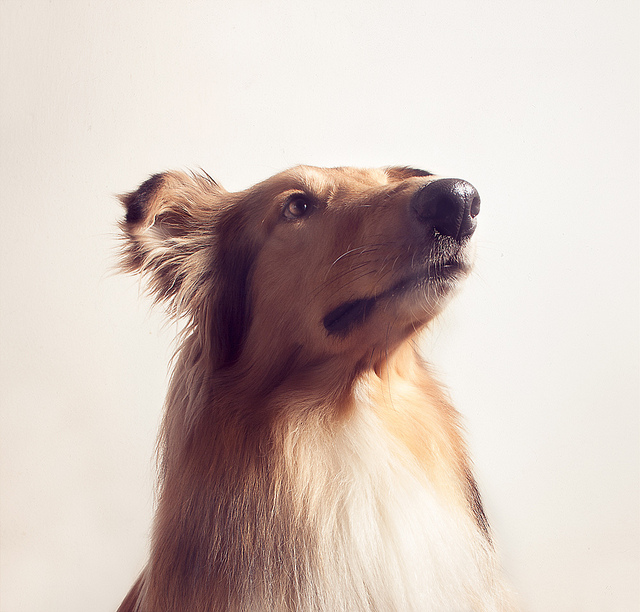

In [76]:
best_images[8]